# Bert Bi-encoders
## Download do bert-portugeuse

In [ ]:
''' 
pip install huggingface_hub
from huggingface_hub import snapshot_download

# Baixa o modelo inteiro para uma pasta local
snapshot_download(
    repo_id="neuralmind/bert-base-portuguese-cased",
    local_dir="./bert-portuguese",
    repo_type="model"
)

# Compacta a pasta em ZIP (manual)
import shutil
shutil.make_archive("bert-portuguese", 'zip', "./bert-portuguese")'''

Fetching 10 files:   0%|          | 0/10 [00:00<?, ?it/s]

tf_model.h5:   0%|          | 0.00/529M [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

flax_model.msgpack:   0%|          | 0.00/436M [00:00<?, ?B/s]

.gitattributes:   0%|          | 0.00/391 [00:00<?, ?B/s]

'd:\\github-projects\\company_name_embendding\\bert-portuguese.zip'

## Importação das bibliotecas e configuração da gpu
foi utilizado uma gforce rtx 3070 de 8gb

In [54]:
import pandas as pd
import json
import random
from sentence_transformers import SentenceTransformer, InputExample, losses, evaluation
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import torch
from tqdm import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"

In [55]:
df = pd.read_parquet("train_clean.parquet")


with open('variacoes_palavras.json', 'r', encoding='utf-8') as f:
    variacoes_dict = json.load(f)

In [56]:
df['texto_empresa'] = df['razaosocial_clean'] + ' ' + df['nome_fantasia_clean']
empresas_unicas = df['texto_empresa'].unique().tolist()

## Geração de erros de consulta, pares positivos e pares negativos

In [ ]:
# Função para gerar variações com erros - BASEADA NA ENTRADA DO USUÁRIO
def gerar_consulta_com_erros(texto_usuario, variacoes_dict):
    palavras = texto_usuario.split()
    for i in range(len(palavras)):
        if palavras[i].lower() in variacoes_dict:
            palavras[i] = random.choice(variacoes_dict[palavras[i].lower()])
    return " ".join(palavras)

# 4. Gerar pares de treino (positivos e negativos)
dados_treino = []

for _, row in df.iterrows():
    texto_empresa = row['texto_empresa']
    consulta_usuario = row['user_input_clean']
    
    # Pares positivos
    dados_treino.append({
        'consulta': consulta_usuario,
        'empresa': texto_empresa,
        'label': 1.0
    })
    
    # Variações com erros (positivos)
    for _ in range(2):
        consulta_erro = gerar_consulta_com_erros(consulta_usuario, variacoes_dict)
        dados_treino.append({
            'consulta': consulta_erro,
            'empresa': texto_empresa,
            'label': 1.0
        })
    
    # Pares negativos (1 negativo para cada positivo)
    for _ in range(3):  # 1 original + 2 variações = 3 positivos
        empresa_aleatoria = random.choice(empresas_unicas)
        while empresa_aleatoria == texto_empresa:
            empresa_aleatoria = random.choice(empresas_unicas)
        
        dados_treino.append({
            'consulta': consulta_usuario,
            'empresa': empresa_aleatoria,
            'label': 0.0
        })


## Separação em treino e teste

In [ ]:
# Divisão treino/validação
train_data, val_data = train_test_split(dados_treino, test_size=0.2, random_state=42)

# Preparar DataLoader - USANDO APENAS POSITIVOS PARA MultipleNegativesRankingLoss
train_examples_positivos = [
    InputExample(texts=[d['consulta'], d['empresa']]) 
    for d in train_data if d['label'] == 1.0
]

### Preparação dos dados de validação e criação do avaliador

In [ ]:
# Preparar validação
val_queries = [d['consulta'] for d in val_data]
val_empresas = [d['empresa'] for d in val_data]
val_labels = [d['label'] for d in val_data]

# Criar avaliador de similaridade
evaluator = evaluation.EmbeddingSimilarityEvaluator(
    val_queries, 
    val_empresas, 
    val_labels,
    name='val'
)

# Configurar modelo e função de perda
model = SentenceTransformer('./bert-portuguese', device=device)
train_loader = DataLoader(train_examples_positivos, shuffle=True, batch_size=32)

# Função de perda adequada para matching textual
loss = losses.MultipleNegativesRankingLoss(model)

No sentence-transformers model found with name ./bert-portuguese. Creating a new one with mean pooling.


### Configuração dos melhores hiperparametros do modelo
❗ Foi feito um early stop no step 50000 devido a falta de ganho de informação considável pelo modelo antes do final da 4 epoch

In [ ]:

model.fit(
    train_objectives=[(train_loader, loss)],
    evaluator=evaluator,
    epochs=4,  
    evaluation_steps=5000,
    output_path='./bert-bi-encoder',
    save_best_model=True,
    show_progress_bar=True,
    warmup_steps=10000,
    checkpoint_path='./bert-bi-encoder-checkpoints',
    checkpoint_save_steps=10000,
    checkpoint_save_total_limit=3
)

print("Treinamento concluído com sucesso!")

Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

Step,Training Loss,Validation Loss,Val Pearson Cosine,Val Spearman Cosine
5000,0.379600,No log,0.900196,0.855235
10000,0.299600,No log,0.916842,0.859073
15000,0.269800,No log,0.926220,0.860344
19155,0.253400,No log,0.930421,0.862831
20000,0.242700,No log,0.931320,0.862605
25000,0.230600,No log,0.931286,0.862479
30000,0.231200,No log,0.933413,0.862891
35000,0.240900,No log,0.936431,0.863313
38310,0.221600,No log,0.937474,0.863622
40000,0.229000,No log,0.938166,0.864122


KeyboardInterrupt: 

#### Carregamento do ultimo checkpoint e salvamento do modelo 

In [ ]:
from sentence_transformers import SentenceTransformer

model_final = SentenceTransformer('./bert-bi-encoder-checkpoints/checkpoint-50000')

In [62]:
model_final.save('./bert-bi-encoder')

## Training Loss vs Correlação de pearson

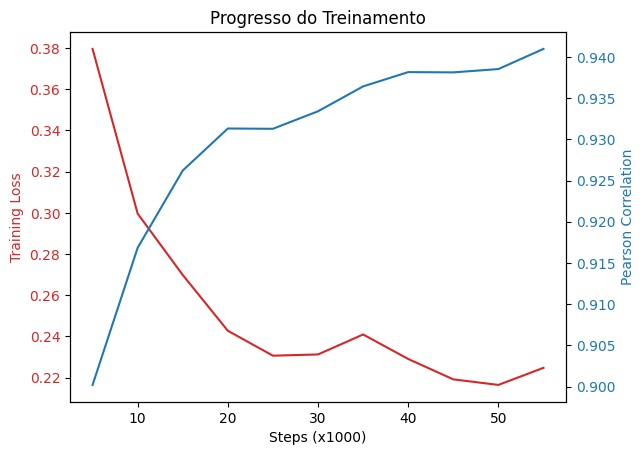

In [66]:
import matplotlib.pyplot as plt
steps = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55]  # x1000

train_loss = [
    0.3796,  # 5
    0.2996,  # 10
    0.2698,  # 15
    0.2427,  # 20
    0.2306,  # 25
    0.2312,  # 30
    0.2409,  # 35
    0.2290,  # 40
    0.2191,  # 45
    0.2164,  # 50
    0.2247]  # 55

pearson = [
    0.900196,  # 5
    0.916842,  # 10
    0.926220,  # 15
    0.931320,  # 20
    0.931286,  # 25
    0.933413,  # 30
    0.936431,  # 35
    0.938166,  # 40
    0.938133,  # 45
    0.938535,  # 50
    0.940980  # 55

]
fig, ax1 = plt.subplots()
ax1.set_xlabel('Steps (x1000)')
ax1.set_ylabel('Training Loss', color='tab:red')
ax1.plot(steps, train_loss, color='tab:red')
ax1.tick_params(axis='y', labelcolor='tab:red')

ax2 = ax1.twinx()
ax2.set_ylabel('Pearson Correlation', color='tab:blue')
ax2.plot(steps, pearson, color='tab:blue')
ax2.tick_params(axis='y', labelcolor='tab:blue')

plt.title('Progresso do Treinamento')
plt.show()

## Teste do modelo no DF completo

In [ ]:

# Carregar o melhor modelo salvo durante o treinamento
model_final = SentenceTransformer('./bert-bi-encoder', device=device)

# Filtrar apenas exemplos positivos do conjunto de validação
test_data = [d for d in val_data if d['label'] == 1.0]

# Criar catálogo de empresas únicas
catalogo_empresas = list(set([d['empresa'] for d in test_data]))
print(f"\nCatálogo de teste contém {len(catalogo_empresas)} empresas únicas")

# Gerar embeddings para todo o catálogo (uma única vez)
print("Gerando embeddings para as empresas do catálogo...")
embeddings_catalogo = model_final.encode(
    catalogo_empresas, 
    batch_size=128,
    show_progress_bar=True,
    convert_to_numpy=True
)

# Mapear empresa -> índice no catálogo
empresa_to_index = {empresa: idx for idx, empresa in enumerate(catalogo_empresas)}

# Inicializar contadores
top1_correct = 0
top5_correct = 0

print("\nIniciando avaliação do modelo...")
from tqdm import tqdm

# Processar cada exemplo de teste
for item in tqdm(test_data):
    consulta = item['consulta']
    empresa_correta = item['empresa']
    
    # Gerar embedding da consulta
    embedding_consulta = model_final.encode(consulta)
    
    # Calcular similaridades com todo o catálogo
    similaridades = cosine_similarity(
        [embedding_consulta],
        embeddings_catalogo
    )[0]
    
    # Ordenar empresas por similaridade (decrescente)
    indices_ordenados = np.argsort(similaridades)[::-1]
    
    # Verificar Top-1
    if catalogo_empresas[indices_ordenados[0]] == empresa_correta:
        top1_correct += 1
        
    # Verificar Top-5
    top5_indices = indices_ordenados[:5]
    top5_empresas = [catalogo_empresas[i] for i in top5_indices]
    if empresa_correta in top5_empresas:
        top5_correct += 1

# 8. Calcular métricas finais
total_exemplos = len(test_data)
top1_accuracy = top1_correct / total_exemplos
top5_accuracy = top5_correct / total_exemplos

print("\n" + "="*60)
print(f"RESULTADOS FINAIS PARA {total_exemplos} EXEMPLOS DE TESTE:")
print(f"Acurácia Top-1: {top1_accuracy:.4f} ({top1_correct}/{total_exemplos})")
print(f"Acurácia Top-5: {top5_accuracy:.4f} ({top5_correct}/{total_exemplos})")
print("="*60)


Catálogo de teste contém 9877 empresas únicas
Gerando embeddings para as empresas do catálogo...


Batches:   0%|          | 0/78 [00:00<?, ?it/s]


Iniciando avaliação do modelo...


100%|██████████| 153476/153476 [2:04:40<00:00, 20.52it/s]  



RESULTADOS FINAIS PARA 153476 EXEMPLOS DE TESTE:
Acurácia Top-1: 0.5710 (87629/153476)
Acurácia Top-5: 0.8404 (128978/153476)
